In [1]:
#!pip install matplotlib

# Imports libs
from ortools.sat.python import cp_model

# Import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Open the file in read mode
# file_path = "p01_dataset_8.txt"
# file_path = "p01_dataset_10.txt"
file_path = "p01_dataset_30.txt"
try:
    with open(file_path, 'r') as file:
        # Read the contents of the file
        contents = file.read()
        # Print the contents
        print("File Contents:\n")
        print(contents)
except FileNotFoundError:
    print(f"The file '{file_path}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

File Contents:

ï»¿************************************************************************
#General Information
projects:  1
jobs (incl. supersource/sink ):  32
horizon:                         141
RESOURCES
  - renewable                 :  4   R
  - nonrenewable              :  0   N
  - doubly constrained        :  0   D
************************************************************************
#Projects summary
pronr. 	#jobs 	rel.date 	duedate 	tardcost 	MPM-Time
 1      30      0         43        0         43
************************************************************************
#Precedence relations
#jobnr.    #modes  #successors   successors
   1        1          3           2   3   4
   2        1          2          23  24
   3        1          3           5   6  17
   4        1          2           7  20
   5        1          3          10  22  28
   6        1          1          18
   7        1          3           8   9  12
   8        1          3          14  21  2

In [3]:
# Function to read and parse the file
def parse_txt_file(file_path):
    data = {}
    section = None
    
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Skip lines with only stars or whitespace
                if line.strip().startswith('*') or not line.strip():
                    continue

                # Identify sections based on headers
                if line.startswith("#General Information"):
                    section = line.strip().lstrip("#")
                    data[section] = []
                elif line.startswith("#Projects summary"):
                    section = line.strip().lstrip("#")
                    data[section] = []
                elif line.startswith("#Precedence relations"):
                    section = line.strip().lstrip("#")
                    data[section] = []   
                elif line.startswith("#Duration and resources"):
                    section = line.strip().lstrip("#")
                    data[section] = []   
                elif line.startswith("#Resource availability"):
                    section = line.strip().lstrip("#")
                    data[section] = []   
                else:
                    # Add content to the current section
                    if section:
                        data[section].append(line.strip())

        # Process data into structured formats
        data['*General_Information'] = parse_general_information(data.get('General Information', []))
        data['*Projects_Summary'] = parse_projects_summary(data.get('Projects summary', []))
        data['*Precedence_Relations'] = parse_precedence_relations(data.get('Precedence relations', []))
        data['*Duration_and_Resources'] = parse_duration_and_resources(data.get('Duration and resources', []))
        data['*Resource_Availability'] = parse_resource_availability(data.get('Resource availability', []))
        
        return data

    except FileNotFoundError:
        print(f"The file '{file_path}' does not exist.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def parse_general_information(lines):
    info = {}
    for line in lines:
        if ":" in line:
            key, value = line.split(":", 1)
            info[key.strip()] = value.strip()
    return info

def parse_projects_summary(lines):
    headers = lines[0].split()
    values = lines[1].split()
    return dict(zip(headers, values))

def parse_precedence_relations(lines):
    headers = lines[0].split()
    headers.append("successors2")
    headers.append("successors3")
    relations = []
    for line in lines[1:]:
        values = line.split()
        while len(values) < 6:
            values.append("0")
        relations.append(dict(zip(headers, values)))
    return relations

def parse_duration_and_resources(lines):
    headers = lines[0].split()
    durations = []
    for line in lines[1:]:
        values = line.split()
        durations.append(dict(zip(headers, values)))
    return durations

def parse_resource_availability(lines):
    headers = lines[0].split()
    resources = []
    for line in lines[1:]:
        values = line.split()
        resources.append(dict(zip(headers, values)))
    return resources

def parse_job_data():
    # Parsing jobs
    jobs = []
    for datax in data['*Duration_and_Resources']:
        job_id = int(datax['#jobnr.'])
        duration = int(datax['duration'])
        resources = {key: int(value) for key, value in datax.items() if key.startswith('R')}
        jobs.append({'id': job_id, 'duration': duration, 'resources': resources})

    # Generate precedence_constraints
    precedence_constraints = []
    for relation in data['*Precedence_Relations']:
        job_id = int(relation['#jobnr.'])
        num_successors = int(relation['#successors'])
        for i in range(1, num_successors + 1):
            successor_key = f'successors{i}' if f'successors{i}' in relation else 'successors'
            successor = int(relation[successor_key])
            if successor != 0:
                precedence_constraints.append((job_id, successor))           
                
    # Generate resources dictionary
    resources = {item['#resource']: int(item['qty']) for item in data['*Resource_Availability']}

    projectTime = data['*Projects_Summary']['MPM-Time']
    
    return jobs, precedence_constraints, resources, projectTime

def plot_gantt_chart(jobs, solver, job_starts, job_ends):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 6))

    # Assign each job a unique color using a colormap
    colors = plt.cm.tab20.colors  # Get a list of colors from the tab20 colormap

    for i, job in enumerate(jobs):
        job_id = job['id']
        start = solver.Value(job_starts[job_id])
        end = solver.Value(job_ends[job_id])
        ax.barh(
            job_id, 
            end - start, 
            left=start, 
            color=colors[i % len(colors)],  # Cycle through colors if there are more jobs than colors
            edgecolor='black', 
            align='center', 
            label=f'Job {job_id}'
        )

    ax.set_yticks([job['id'] for job in jobs])
    ax.set_yticklabels([f'Job {job["id"]}' for job in jobs])
    ax.set_xlabel('Days')
    ax.set_ylabel('Jobs')
    ax.set_title('Job Schedule Project 1')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Jobs')
    plt.tight_layout()
    plt.show()

def print_job_schedule(jobs, solver, job_starts, job_ends):
    """
    Prints a textual representation of the job schedule.
    """
    print(f"{'Job ID':<10}{'Start Time':<15}{'End Time':<15}{'Duration':<10}")
    print("-" * 50)
    for job in jobs:
        job_id = job['id']
        start = solver.Value(job_starts[job_id])
        end = solver.Value(job_ends[job_id])
        duration = job['duration']
        print(f"{job_id:<10}{start:<15}{end:<15}{duration:<10}")


In [4]:
#Read file and parse data
data = parse_txt_file(file_path)

Precedence Constraints: [(1, 2), (1, 3), (1, 4), (2, 23), (2, 24), (3, 5), (3, 6), (3, 17), (4, 7), (4, 20), (5, 10), (5, 22), (5, 28), (6, 18), (7, 8), (7, 9), (7, 12), (8, 14), (8, 21), (8, 27), (9, 11), (9, 16), (10, 16), (11, 17), (12, 13), (12, 15), (12, 16), (13, 30), (14, 19), (15, 26), (16, 25), (17, 24), (18, 21), (19, 25), (20, 25), (20, 27), (21, 22), (22, 29), (22, 30), (23, 31), (24, 27), (25, 26), (26, 30), (27, 28), (28, 31), (29, 32), (30, 32), (31, 32)]
Resources: {'R1': 10, 'R2': 8, 'R3': 13, 'R4': 12}
Minimized makespan: 47.0
Job 1: Start at 0, End at 0
Job 2: Start at 0, End at 1
Job 3: Start at 0, End at 1
Job 4: Start at 0, End at 1
Job 5: Start at 1, End at 8
Job 6: Start at 1, End at 7
Job 7: Start at 1, End at 5
Job 8: Start at 11, End at 16
Job 9: Start at 5, End at 13
Job 10: Start at 8, End at 15
Job 11: Start at 13, End at 21
Job 12: Start at 5, End at 6
Job 13: Start at 16, End at 18
Job 14: Start at 16, End at 19
Job 15: Start at 6, End at 16
Job 16: Star

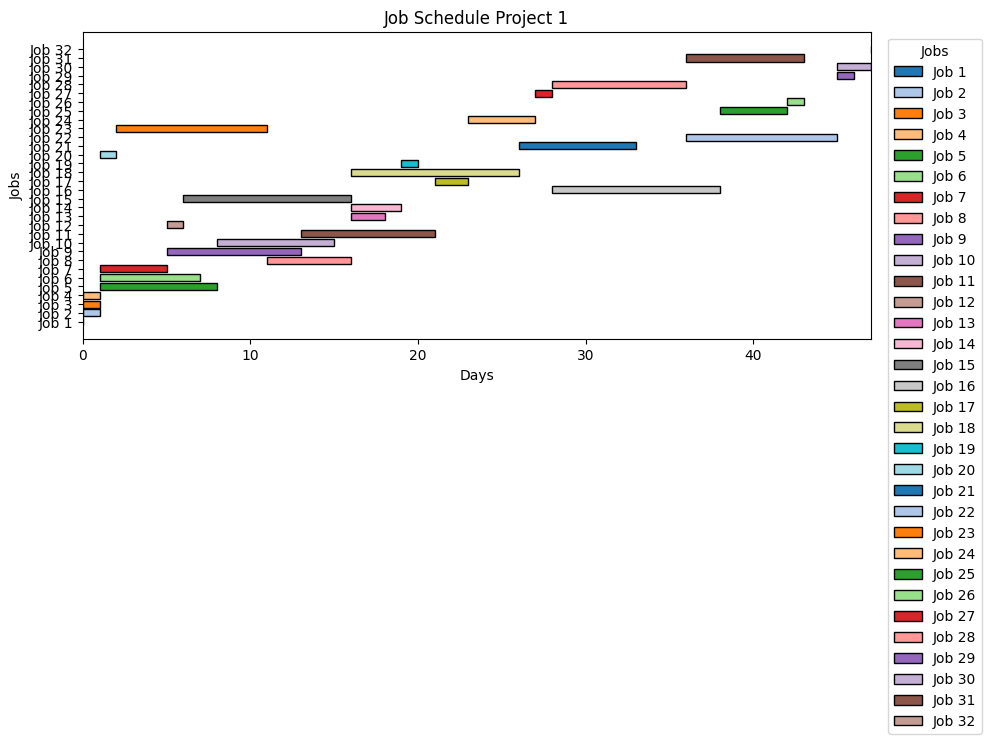

In [5]:
def main():   
    
    # Call the function to get File Structure    
    jobs, precedence_constraints, resources, projectExactTime = parse_job_data()

    # print("Domain jobs:", jobs)
    print("Precedence Constraints:", precedence_constraints)
    print("Resources:", resources)

    # Create the model
    model = cp_model.CpModel()

    job_starts = {}
    job_ends = {}
    intervals = []
    resource_intervals = {resource: [] for resource in resources}

    # Create Domain Variables
    ''' 
        jobs: Domain jobs[i] , i was the number of jobs
        start_var: The start time of each job.
        end_var: The end time of each job.
        interval_var: An interval variable that combines start_var, duration, and end_var.
        makespan: Represents the overall project completion time.
    '''
    
    for job in jobs:
        job_id = job['id']
        duration = job['duration']
        resource_usage = job['resources']
        
        start_var = model.NewIntVar(0, sum(j['duration'] for j in jobs), f'start_{job_id}')
        end_var = model.NewIntVar(0, sum(j['duration'] for j in jobs), f'end_{job_id}')
        interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job_id}')

        job_starts[job_id] = start_var
        job_ends[job_id] = end_var
        intervals.append(interval_var)

        for resource, usage in resource_usage.items():
            if usage > 0:
                resource_intervals[resource].append((interval_var, usage))

    # Apply Constrains
    # Precedences
    for before, after in precedence_constraints:        
        model.Add(job_starts[after] >= job_ends[before])

    # Force start with Job 1
    model.Add(job_starts[1] == 0)    
    
    # Resource
    for resource, intervals_with_usage in resource_intervals.items():
        intervals_only = [i[0] for i in intervals_with_usage]
        usages = [i[1] for i in intervals_with_usage]
        model.AddCumulative(intervals_only, usages, resources[resource])
    
    # The makespan is the latest time at which any job finishes. 
    # If the solver finds a solution that minimizes the makespan but doesn't start Job 1 at time 0
    # it may choose to start other jobs first based on resource or precedence constraints. 
    # In this case, the solver may be minimizing the total completion time, which could result in Job 1 starting later to achieve the best overall schedule.    
    # Minimize the makespan (overall project completion time)
    sumDuration = sum(j['duration'] for j in jobs)
    makespan = model.NewIntVar(0, sumDuration, 'makespan')
    model.AddMaxEquality(makespan, [job_ends[j['id']] for j in jobs])

    # Constraint the makespan to be within projectExactTime
    # model.Add(makespan <= projectExactTime) 

    # Optimize Domains
    # Artificial objective to prioritize smaller IDs
    # priority_weights = {job['id']: (job['id'] if job['id'] != 1 else 100) for job in jobs}  # Increase priority of Job 1
    # objective = sum(priority_weights[job['id']] * job_starts[job['id']] for job in jobs)
    
    # Combine both objectives: minimize makespan and prioritize smaller IDs
    # combined_objective = makespan + objective
    # model.Minimize(combined_objective)
    model.Minimize(makespan)
    
    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # Output the results
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f'Minimized makespan: {solver.ObjectiveValue()}')
        for job in jobs:
            job_id = job['id']
            print(f'Job {job_id}: Start at {solver.Value(job_starts[job_id])}, End at {solver.Value(job_ends[job_id])}')
        
        print_job_schedule(jobs, solver, job_starts, job_ends)
    # Plot the Gantt chart
        plot_gantt_chart(jobs, solver, job_starts, job_ends)      
    else:
        print('No feasible solution found.')

if __name__ == '__main__':
    main()
